In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL-H1/

Mounted at /gdrive
/gdrive/My Drive/ANNDL-H1


In [2]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow import keras
#!pip install visualkeras
import visualkeras
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
%load_ext autoreload
%autoreload 2

2.10.0


In [3]:
import sys
sys.path.append('../../../Utils/')
from DatasetHelper import DatasetHelper
from ModelHelper import ModelHelper

## Helper Configuration:
Configure
 the helper classes by setting a seed and the root folder path

In [4]:
#Create Instances Of Utils Helper
seed = 42
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4',4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../",42) #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper   = ModelHelper("../../",labels) #take in input local models folder and lables
model_helper.create_seed(tf,seed);

# Dataset Loading and Preprocessing

Load dataset and apply all the preprocessing operations
- Splitting
- Normalization
- Augmentation

In [6]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
#X,Y = dataset_helper.load_Dataset(22)

dataset_size = X.shape[0]
print("Dataset Size" + str(dataset_size))

#SPLIT and NORMALIZE OUR DATASET
X_train,X_test,X_val,Y_train,Y_test,Y_val = dataset_helper.split_and_normalize(X,Y,split_test=0.1,split_val=0.1,normalization_mode = 1)

#GENERATE 3000 new images
X_train,Y_train = dataset_helper.apply_data_augmentation(X_train,Y_train,3000)


Dataset Size3542
BB
STOP CONDITION; 93
(2870, 96, 96, 3)


100%|██████████| 93/93 [00:42<00:00,  2.17it/s]


(5836, 96, 96, 3)
(5836, 8)


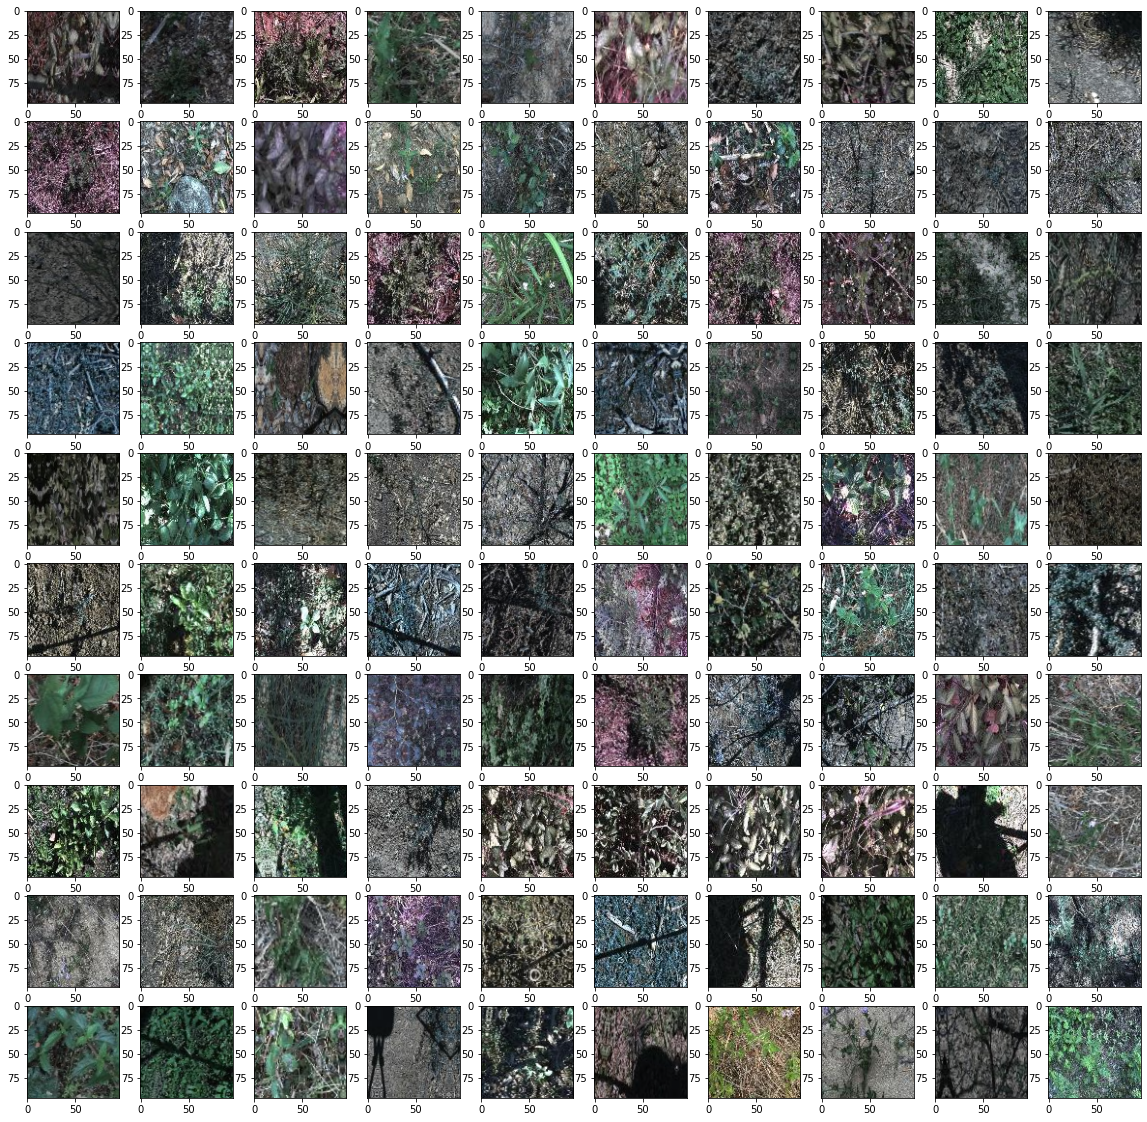

In [7]:
start = 5000
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow((X_train[start+i]*255).astype(np.uint8))
plt.show()

# Define the model Structure
Create a function that declare all the model components

In [11]:
#Create the Model
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv0 =tfkl.Conv2D(
        filters=32,
        kernel_size=(7, 7),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)

    pool0 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv0)

    conv1 = tfkl.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool0)
    pool1 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv1)

    conv2_1 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    conv2_2 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv2_1)
    pool2 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv2_2)

    conv3_1 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    conv3_2 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv3_1)
    pool3 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv3_2)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    classifier_layer = tfkl.Dense(
        units=256, 
        name='Classifier', 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(flattening_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(
        units=8, 
        activation='softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

# Training Phase
Compile the model, configure all necessary infomation for training like epoch,batches, callbacks...
Then start the training

### Compile the model

In [12]:
#Build the model
input_shape = X_train.shape[1:]#(None,96,96,3)
batch_size = 128
epochs = 200

model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

NameError: name 'X_train' is not defined

### Train the model

In [20]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,patience=25)

#Fit the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/200
70/70 [==============================] - 7s 74ms/step - loss: 2.0390 - accuracy: 0.2142 - val_loss: 2.2709 - val_accuracy: 0.1509
Epoch 2/200
70/70 [==============================] - 5s 70ms/step - loss: 1.9886 - accuracy: 0.2058 - val_loss: 2.1235 - val_accuracy: 0.3113
Epoch 3/200
70/70 [==============================] - 5s 69ms/step - loss: 1.8859 - accuracy: 0.2709 - val_loss: 1.8160 - val_accuracy: 0.2642
Epoch 4/200
70/70 [==============================] - 5s 70ms/step - loss: 1.7482 - accuracy: 0.3274 - val_loss: 1.6592 - val_accuracy: 0.3774
Epoch 5/200
70/70 [==============================] - 5s 71ms/step - loss: 1.6312 - accuracy: 0.3792 - val_loss: 2.2778 - val_accuracy: 0.2516
Epoch 6/200
70/70 [==============================] - 5s 71ms/step - loss: 1.5670 - accuracy: 0.4028 - val_loss: 1.4898 - val_accuracy: 0.4308
Epoch 7/200
 5/70 [=>............................] - ETA: 4s - loss: 1.5188 - accuracy: 0.4219

KeyboardInterrupt: ignored

In [10]:
#model_helper.save_model(model,"ExampleModel4")

model = model_helper.load_model("ExampleModel3")

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)       73856 

12/12 [==============================] - 0s 14ms/step
Accuracy: 0.5791
Precision: 0.5179
Recall: 0.5156
F1: 0.5122


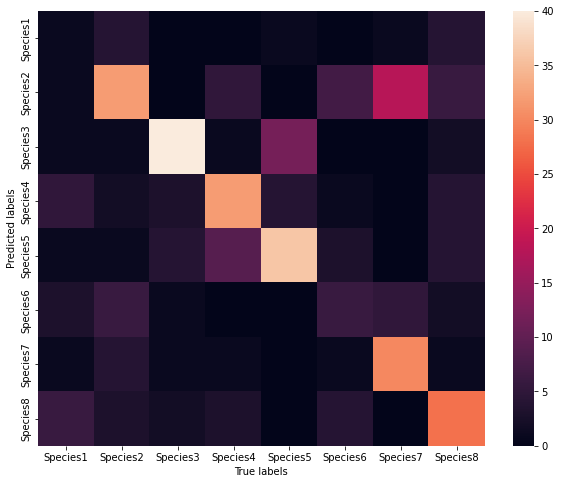

BABABA


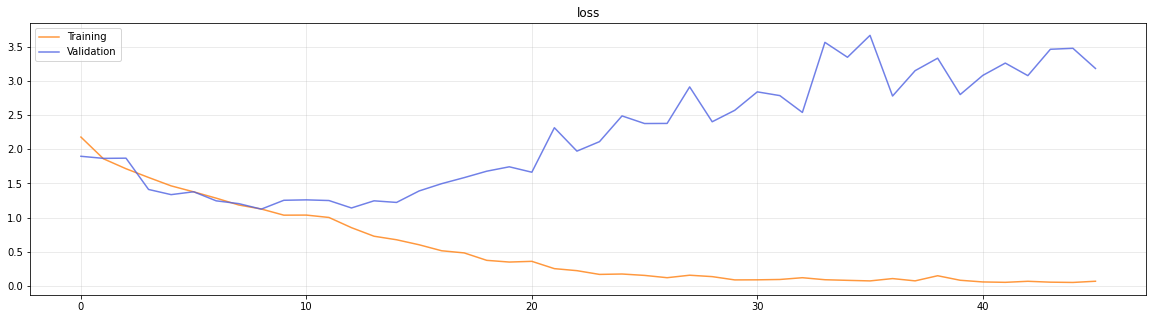

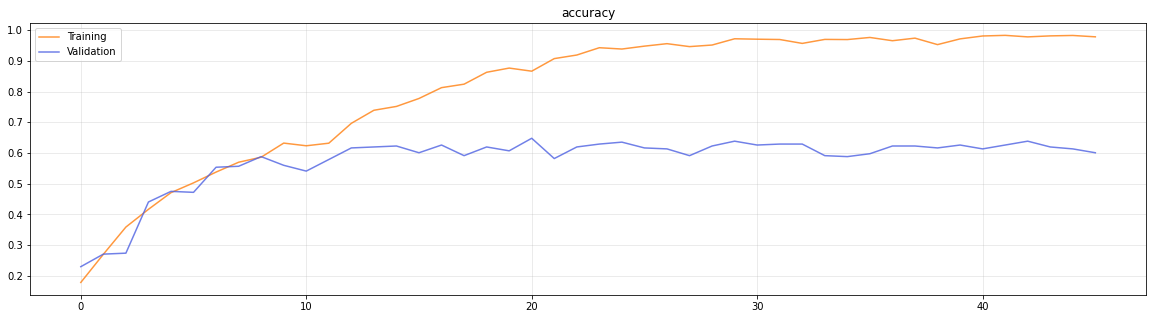

In [13]:
model_helper.show_confusion_matrix(X_test,Y_test)
model_helper.plot_phase_train_vs_validation(history)